# AIR TANKS STICKER TRAIN MODEL

### Import the modules

In [12]:
import os
import cv2 as cv
import random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

### Path and model variables

In [13]:
ROOT = '.'
PATH = ROOT + "./machine-learning/"
TRAIN_PATH = PATH + "train"
TEST_PATH = PATH + "test"
IMG_SIZE = 32
CHANNELS = 1
LABEL_FILE = 'labels.txt'

### Get the labels from file

In [14]:
labels = []
with open(PATH + LABEL_FILE, "r") as file:
    labels = file.read().splitlines()

num_classes = len(labels)
print('Labels: ' + str(labels))
print('Number of classes: ' + str(num_classes))

Labels: ['sticker_1', 'sticker_2', 'sticker_p', 'sticker_t', 'sticker_1_180', 'sticker_2_180', 'sticker_p_180', 'sticker_t_180', 'sticker_1_90', 'sticker_2_90', 'sticker_p_90', 'sticker_t_90']
Number of classes: 12


### Extract the images from the folder, load them into an array, convert them to gray if necessary and attach its labels

In [15]:
i = 0
dataset = []
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)

for folder in labels:    
    counter = 0
    files = os.listdir(f'../images/{labels[i]}')
    for file in files:
        ext = file.split('.')[-1]
        if ext in ['jpg', 'png']:
            img = cv.imread(f'../images/{labels[i]}/{file}')
            if CHANNELS == 1:
                img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, input_shape[:2])
            dataset.append([img, i])
            counter += 1
    print(f'Add {counter} images with label {labels[i]} ')
    i += 1

X = []
y = []

for image, label in dataset:
    X.append(image)
    y.append(label)

print(f'\nTotal images: {len(dataset)}')

Add 126 images with label sticker_1 
Add 105 images with label sticker_2 
Add 45 images with label sticker_p 
Add 36 images with label sticker_t 
Add 105 images with label sticker_1_180 
Add 98 images with label sticker_2_180 
Add 45 images with label sticker_p_180 
Add 36 images with label sticker_t_180 
Add 106 images with label sticker_1_90 
Add 99 images with label sticker_2_90 
Add 90 images with label sticker_p_90 
Add 52 images with label sticker_t_90 

Total images: 943


### Sample one image

Label: sticker_1_90


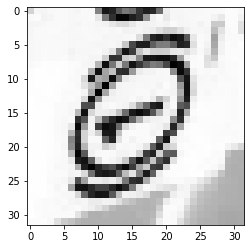

In [16]:
index = random.randint(0,len(dataset) - 1)
image = dataset[index][0]
label = labels[dataset[index][1]]
plt.imshow(image, cmap='gray')
print(f'Label: {label}')


### Convert the images to tensors and normalize them

In [17]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)
X = X / 255

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

x_train_mean = np.mean(X_train, axis=0)
X_train -= x_train_mean
X_test -= x_train_mean

y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

#### Create the model

In [18]:
model = Sequential()

model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=input_shape, activation="relu")
)
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax", kernel_initializer='he_normal'))


log_dir = 'logs\\fit'

board = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

# Compile and Train
model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

### Train

In [19]:
batch_size = 4
epochs = 10
callbacks = [EarlyStopping(patience=2), board]

model.fit(X_train, y_cat_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_split=0.1, )

Epoch 1/10
191/191 [==============================] - 5s 24ms/step - loss: 1.9108 - accuracy: 0.3434 - val_loss: 1.2976 - val_accuracy: 0.6353
Epoch 2/10
191/191 [==============================] - 4s 20ms/step - loss: 0.7563 - accuracy: 0.7497 - val_loss: 0.6239 - val_accuracy: 0.8235
Epoch 3/10
191/191 [==============================] - 4s 19ms/step - loss: 0.3978 - accuracy: 0.8820 - val_loss: 0.4719 - val_accuracy: 0.8353
Epoch 4/10
191/191 [==============================] - 4s 19ms/step - loss: 0.2633 - accuracy: 0.9148 - val_loss: 0.3104 - val_accuracy: 0.8941
Epoch 5/10
191/191 [==============================] - 4s 21ms/step - loss: 0.1898 - accuracy: 0.9423 - val_loss: 0.3065 - val_accuracy: 0.8941
Epoch 6/10
191/191 [==============================] - 4s 20ms/step - loss: 0.0974 - accuracy: 0.9738 - val_loss: 0.2396 - val_accuracy: 0.9059
Epoch 7/10
191/191 [==============================] - 4s 21ms/step - loss: 0.0838 - accuracy: 0.9738 - val_loss: 0.2182 - val_accuracy: 0.9176

#### Evaluate the model

In [9]:
loss, acc = model.evaluate(X_test, y_cat_test)

print("LOSS: {}, ACC: {}".format(loss, acc * 100))

pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, pred))

3/3 [==============================] - 0s 11ms/step - loss: 0.3175 - accuracy: 0.9158
LOSS: 0.31749677658081055, ACC: 91.57894849777222
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.69      0.82      0.75        11
           2       1.00      1.00      1.00         6
           3       0.80      1.00      0.89         4
           4       0.89      1.00      0.94         8
           5       1.00      0.67      0.80        12
           6       1.00      1.00      1.00         4
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00        10
           9       1.00      0.90      0.95        10
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6

    accuracy                           0.92        95
   macro avg       0.94      0.93      0.93        95
weighted avg       0.93      0.92      0.92        9

### Write model to file

In [10]:
now = datetime.now()
str_date = now.strftime("%Y-%m-%d_%H%M%S")
file_name = f"../models/stickers_{IMG_SIZE}x{IMG_SIZE}.h5"

model.save(file_name)

print("TRAINING PROCESS DONE!\n")

TRAINING PROCESS DONE!



In [11]:
# %cd ..
%tensorboard --logdir ../logs

UsageError: Line magic function `%tensorboard` not found.
